# Matplotlib for petrophysicists

Be sure to check out [`Intro_to_matplotlib.ipynb`](./Intro_to_matplotlib.ipynb) for similar lessons with different geoscience examples!

For this notebooks, you will need to have install `dlisio` in your `geocomp` environment: `pip install geocomp`

The data used in this notebook is from various files from Utah FORGE project: Well 58-32. This data is publically available on the [Geothermal Data Repository](http://gdr.openei.org/submissions/1076)

Energy and Geoscience Institute at the University of Utah. (2018). Utah FORGE: Well 58-32 Schlumberger FMI Logs DLIS and XML files [data set].  Retrieved from https://dx.doi.org/10.15121/1464529.

In [1]:
# %pip install dlisio

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from welly import Well, Project
import dlisio
import pandas as pd
import dlis_utils

ModuleNotFoundError: No module named 'dlisio'

Let's get some well data to play with.

In [3]:
url = 'https://geocomp.s3.amazonaws.com/data/UniversityOfUtah_MU-ESW1_DSI_PnS-Aniso_SecondPass.las'
well = Well.from_las(url, index='original')

In [4]:
well = Well.from_las('https://geocomp.s3.amazonaws.com/data/DSI_PnS-Aniso_1stRun.las', index='original')

In [4]:
well

Well(uwi: '1771001M00', 31 curves: ['MD', 'BS', 'DPHZ', 'DTCO', 'DTSM_FAST', 'DTSM_SLOW', 'FSA_ERRMINUS', 'FSA_ERRPLUS', 'FSA_FINAL', 'FSA_P1AZ', 'GR_EDTC', 'HAZIM', 'HDAR', 'MAXXENE_OVERALL_BCR_5', 'MINXENE_OVERALL_BCR_5', 'P1AZ', 'PEFZ', 'PR_FAST', 'RHOZ', 'SDEVM', 'SLOANI', 'SPHI', 'TDIF_ALT_OVERALL_BCR_5_SWAP_6', 'TDIF_ORG_OVERALL_BCR_5_SWAP_6', 'TENS', 'TIMANI', 'TNPH', 'TW_B', 'TW_E', 'VPVS_FAST', 'XENEDIF'])

We can create numpy array from each of these curves using the `Curve` object's `values` attribute. Let's start by renaming some variables for the p-sonic, s-sonic (fast), s-sonic (slow), and bulk density, and hole diameter (HDAR). Each `Curve` has a depth array associated with it as an attribute (i.e. `well.data['DTCO'].basis`), but we can also create a variable called `depth` that works for all the curves here because all these curves came from the same file.

In [5]:
dt = well.data['DTCO'].values
dtsm_slow = well.data['DTSM_SLOW'].values
dtsm_fast = well.data['DTSM_FAST'].values
rhoz = well.data['RHOZ'].values
diam = well.data['HDAR'].values
depth = well.data['RHOZ'].basis

In [6]:
type(dt)

numpy.ndarray

## First steps
The first step is usually just a quick plot.

If we have a simple 1D array of numbers, we just pass y, and x will be generated from the indices of the elements.

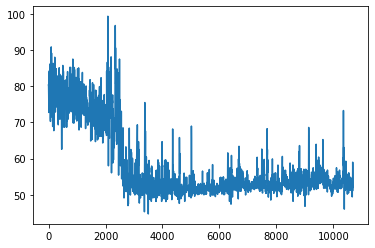

In [7]:
plt.plot(dt)

This is the pyplot interface to matplotlib. It's the easiest one to use, but it's less flexible than the so-called 'object-oriented' interface.

Here's the official tutorial for the pyplot interface: https://matplotlib.org/tutorials/introductory/pyplot.html

Producing the same plot with the object-oriented interface looks like this:

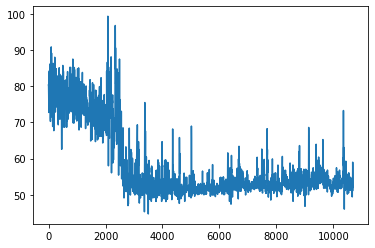

In [8]:
fig, ax = plt.subplots()
ax.plot(dt)

For the rest of this lesson, we're going to use the object-oriented approach.

### Exercise
- Plot the data vertically, with depth on the y-axis instead of `dt`. You will need to pass both arrays to the `plot` method: `ax.plot(x, y)`.
- Add `color='red'` to your call to plot.
- What happens if you add another line with `ax.set_ylim(7000, 7500)`?
- Can you display the whole well with 0 at the top?
- Try instantiating the figure with `plt.subplots(figsize=(2,10))` at the start.

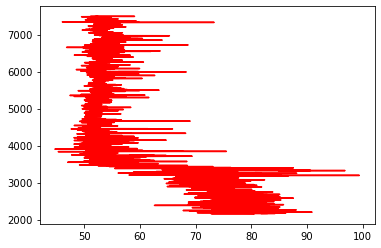

In [9]:
fig, ax = plt.subplots()
ax.plot(dt, depth, 'r')

(7500.0, 7000.0)

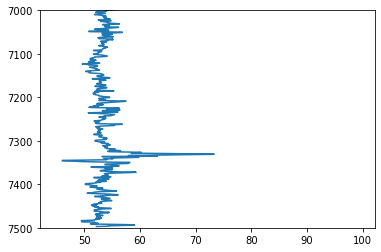

In [10]:
fig, ax = plt.subplots()

ax.plot(dt, depth)
ax.set_ylim(7500, 7000)

Text(0.5, 0, 'DTCO [µs/m]')

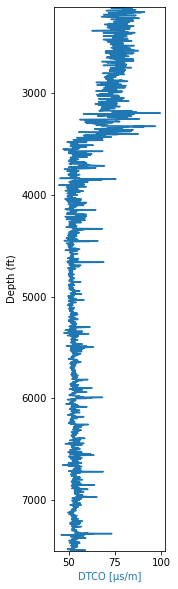

In [11]:
fig, ax = plt.subplots(figsize=(2, 10))
ax.plot(dt, depth, color='tab:blue')
ax.set_ylim(depth[-1], depth[0])
ax.set_ylabel('Depth (ft)')
ax.set_xlabel('DTCO [µs/m]', color='tab:blue')

## `plt.hist()`

We often want to look at the distribution of our data. 

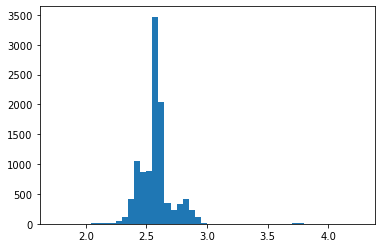

In [12]:
_ = plt.hist(rhoz, bins=50)

### Exercise
- Create a new array called `rhoz_clipped` that clips the RHOZ values below 2.0 and above 3.0 g/cm³
- Create a copy of `rhoz` and use it to create a third array called `rhoz_nan` where values below 2.0 and above 3.0 are set to NaNs (missing / empty). Hint: you will have to write a condition and use that to index into `rhoz`.
- Plot a histogram from these two arrays (rhoz_clipped and rhoz_nan) in the same plot. Which one do you prefer?
- Create an updated display of the two log tracks using 2.0 to 3.0 g/cm³ as the x-axis range.

In [13]:
# let's deal with the spurious values in the density log two ways:
rhoz_clipped = np.clip(rhoz, 2.0, 3.0)

In [14]:
rhoz_nan = rhoz.copy()  # makes a copy of the array 
rhoz_nan[(rhoz < 2.0) | (rhoz > 3.0)] = np.nan

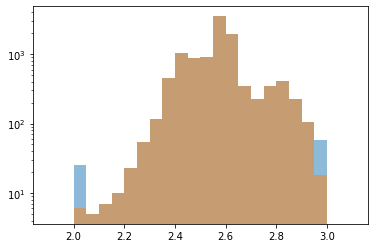

In [15]:
_ = plt.hist(rhoz_clipped, alpha=0.5, bins=np.arange(1.9, 3.1, 0.05),  log=True, label='rhob_clipped')
_ = plt.hist(rhoz_nan, alpha=0.5, bins=np.arange(1.9, 3.1, 0.05), log=True, label='rhob_nan')

For discussion: Is it better to have missing data, or clipped data? Or do we need to do something more clever for spurious values? For instance, is it better to set a variable clip data based on some moving threshold down the log? Also, are there other curves that we need to bring to bear? E.g. Caliper, HDRA, etc?

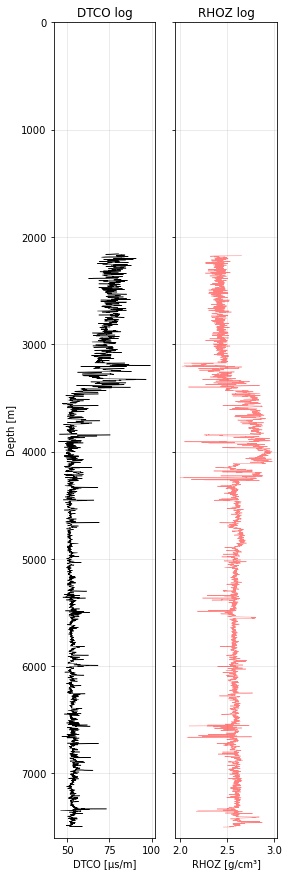

In [16]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(4, 15), sharey=True)

ax0.plot(dt, depth, lw=0.5, c='black')
ax0.set_ylim(depth[-1]+100, 0)
ax0.set_xlabel('DTCO [µs/m]')
ax0.set_ylabel('Depth [m]')
ax0.set_title('DTCO log')
ax0.grid('k', alpha=0.3)

ax1.plot(rhoz_nan, depth, 'red', lw=0.5, alpha=0.5)
ax1.set_ylim(depth[-1]+100, 0)
ax1.set_xlabel('RHOZ [g/cm³]')
ax1.set_title('RHOZ log')
ax1.grid('k', alpha=0.3)

plt.show()  # <--- Note that you need this in a script.

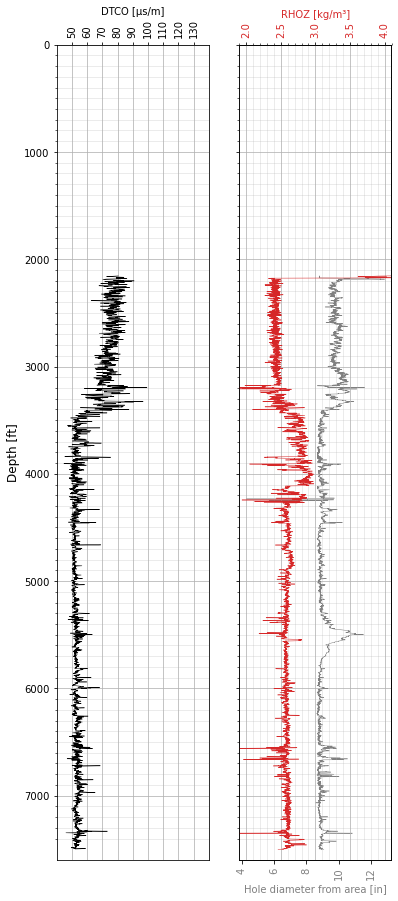

In [17]:
# Here is an example of adding a second track with RHOZ and Hole Diameter (HDAR)
# It's pretty invovled, but it give you an idea of how to customize and control 
# various elements of the axes objects.

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(6, 15), sharey=True)

# First "track"
dt_color = 'black'
major_ticks_left=np.arange(0,depth[-1],1000)
minor_ticks_left=np.arange(0,depth[-1],100)
ax0.set_yticks(major_ticks_left)
ax0.set_yticks(minor_ticks_left,minor=True)
ax0.plot(dt, depth, lw=0.5, c=dt_color)
ax0.set_ylim(depth[-1]+100, 0)
ax0.set_xlabel('DTCO [µs/m]', color=dt_color)
ax0.set_ylabel('Depth [ft]', fontsize=12)
ax0.xaxis.tick_top()
ax0.xaxis.set_label_position('top')
ax0.set_xticks(np.arange(50,140,10))
ax0.tick_params(axis='x', labelrotation=90)
ax0.set_xlim(40,140)
ax0.tick_params(axis='x', labelcolor=dt_color)
ax0.grid(which="major",alpha=0.75, lw=1.0)
ax0.grid(which="minor",alpha=0.3)

# Second "track"
# We can do a twinned y-axis to plot the hole diameter.
# In other words, for ax2 we are keeping the y-axis the same as ax1
# and using a different x-axis
# we put in ax1 the curve we want labelled on the bottom. Otherwise
# it take considerably more code to do the opposite.

major_ticks_top=np.arange(1,5,0.5) # vertical gridlines for rhoz
minor_ticks_top=np.arange(1,5,0.1) # vertical gridlines for rhoz

diam_color = 'grey'
ax1.plot(diam, depth, color=diam_color, lw=0.5)
ax1.set_xlabel('Hole diameter from area [in]', color=diam_color)
ax1.tick_params(axis='x', labelcolor=diam_color)
ax1.grid(which="major",alpha=0.75, lw=1.0, axis='y')
ax1.grid(which="minor",alpha=0.3, axis='y')
ax1.tick_params(axis='x', labelrotation=90)

# we put in ax2 the curve we want labelled on the top (unsure)
rhoz_color = 'tab:red'
ax2 = ax1.twiny()
ax2.set_xticks(major_ticks_top)
ax2.set_xticks(minor_ticks_top,minor=True)
ax2.grid(which="major",alpha=0.75, lw=1.0, axis='x')
ax2.grid(which="minor",alpha=0.3, axis='x')
ax2.plot(rhoz, depth, color=rhoz_color, lw=0.5)
ax2.set_ylim(depth[-1]+100, 0)
ax2.set_xlabel('RHOZ [kg/m³]', color=rhoz_color)
ax2.tick_params(axis='x', labelrotation=90)
ax2.tick_params(axis='x', labelcolor=rhoz_color)
ax2.set_xlim(1.9, 4.1)

plt.show()  # <--- Note that you need this in a script.

## `plt.scatter()`

It's also easy to make scatter plots:

Text(0, 0.5, 'RHOZ [kg/m³]')

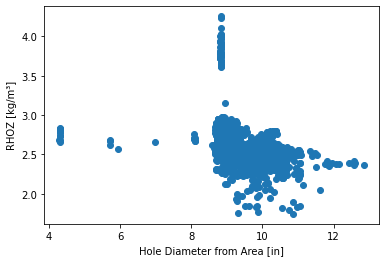

In [18]:
fig, ax = plt.subplots()
ax.scatter(diam, rhoz)
ax.set_xlabel('Hole Diameter from Area [in]')
ax.set_ylabel('RHOZ [kg/m³]')

Text(0, 0.5, 'RHOZ [kg/m³]')

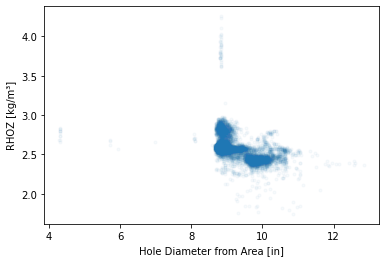

In [19]:
fig, ax = plt.subplots()
ax.scatter(diam, rhoz, s=10, alpha=0.03)
ax.set_xlabel('Hole Diameter from Area [in]')
ax.set_ylabel('RHOZ [kg/m³]')

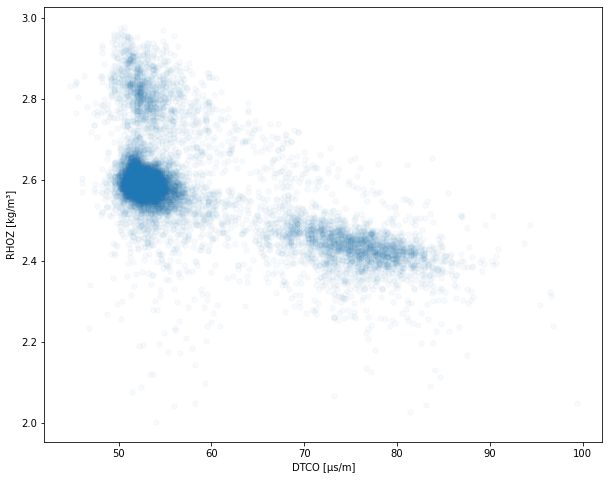

In [20]:
# look at only density values from 2.0 to 3.0 from rhoz_nan
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(dt, rhoz_nan, s=30, alpha=0.03)
ax.set_xlabel('DTCO [µs/m]')
_ = ax.set_ylabel('RHOZ [kg/m³]')

We can adjust how the points plot to make it more interesting. Adjust the size `s`

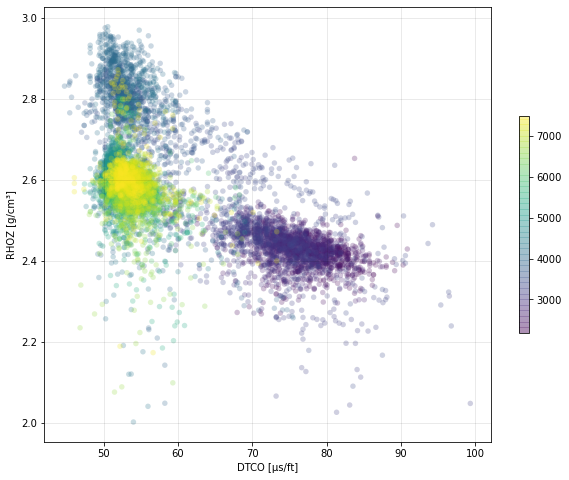

In [21]:
fig, ax = plt.subplots(figsize=(10,8))
scat = ax.scatter(dt, rhoz_nan, c=depth, s=30, alpha=0.25, ec=None)
ax.set_xlabel('DTCO [µs/ft]')
ax.set_ylabel('RHOZ [g/cm³]')
ax.grid(c='k', alpha=0.1)
fig.colorbar(scat, shrink=0.5)
plt.show()

# Dealing with units

The classic seismic rock physics template is Acoustic Impedance versus Vp/Vs ratio. The units of Impedance are bit odd, and we might forget that VpVs is dimensionless, so let's keep track of them using `pint`.

There is a [comprehensive tutorial](https://pint.readthedocs.io/en/stable/) if you want more examples.

In [22]:
import pint

In [23]:
# The unit registry stores the definitions and relationships between units
ureg = pint.UnitRegistry()

In [24]:
slowness_units = ureg.second * 1e-6 / ureg.feet 

In [25]:
slowness_units

1e-06 <Unit('second / foot')>

In [26]:
# let's get the units for slowness.
p_slowness = dt * slowness_units
p_velocity = 1 / p_slowness  
p_velocity = p_velocity.to('m/s')
p_velocity

array([3789.98414623, 3789.98414623, 3882.34754653, ...,           nan,
                 nan,           nan]) <Unit('meter / second')>

### Exercise
- Create a new array called `density` which has density in SI units (kg/m³). Hint: you can look up the units 
of the `RHOZ` curve with `well.data['RHOZ'].units`
- Calculate Acoustic Impedance, $\rho V_{p}$ and store it on a variable called `ac_imp`. Use pint to ensure that this quantity is in the SI units of kg/m²s.
- Calulate $V_{P}/V_{S}$ from `dt` for p-sonic and `dtsm_fast` for s-sonic. This is a ratio of velocities so use pint to ensure you get a dimensionless quantity.

In [27]:
well.data['RHOZ']

Curve([4.106 , 4.0159, 3.9702, ..., 2.5155, 2.4838, 2.4604])

In [28]:
str_units = well.data['RHOZ'].units.replace('3','**3')
str_units

'g/cm**3'

In [29]:
density = rhoz_nan * ureg(str_units) 
# alternate ways:
# density = rhoz_nan * ureg.gram / ureg.cc  
# density = rhoz_nan * ureg.gram / centimeter**3
density = density.to('kg/m**3')
density

array([   nan,    nan,    nan, ..., 2515.5, 2483.8, 2460.4]) <Unit('kilogram / meter ** 3')>

In [30]:
ac_imp = p_velocity * density

In [31]:
# we need to make s-sonic a  s_velocity 
s_slowness = dtsm_fast * slowness_units
s_velocity = 1 / s_slowness
# remark how if you do p_velocity / s_velocity at this point you'll get
# something with units of foot / meter
s_velocity = s_velocity.to('m/s')
vpvs = p_velocity / s_velocity
vpvs.units

<Unit('dimensionless')>

/home/geodev/anaconda3/envs/geocomp/lib/python3.8/site-packages/numpy/ma/core.py:2831: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  _data = np.array(data, dtype=dtype, copy=copy,


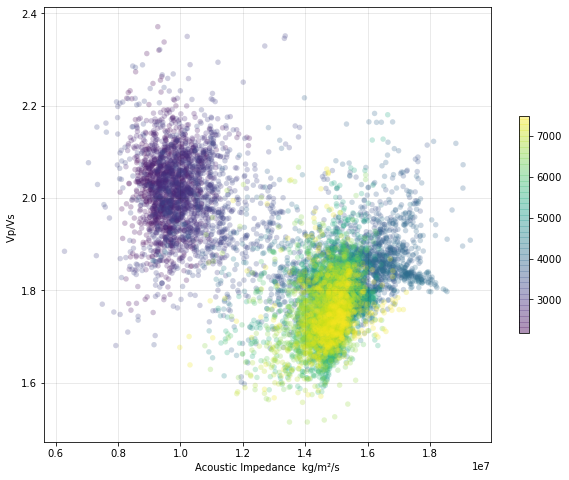

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
scat = ax.scatter(ac_imp, vpvs, c=depth, s=30, alpha=0.25, ec=None)
ax.set_xlabel(f'Acoustic Impedance  {ac_imp.units:~P}')
ax.set_ylabel(f'Vp/Vs  {vpvs.units:~P}')
ax.grid(c='k', alpha=0.1)
fig.colorbar(scat, shrink=0.5)

In general, `seaborn` makes nicer histograms, and adds a KDE (kernel density estimation) plot. It also prefers data without NaNs though...

<AxesSubplot:ylabel='Count'>

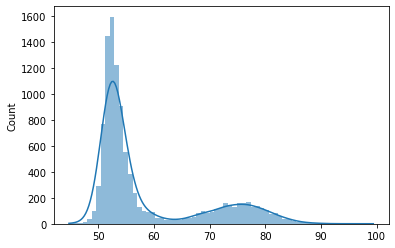

In [33]:
import seaborn as sns

sns.histplot(dt, kde=True, lw=0)

## `plt.bar()`

We can use the data from `plt.hist()` to make our own bar chart. First, let's check what we get back:

(67, 68)

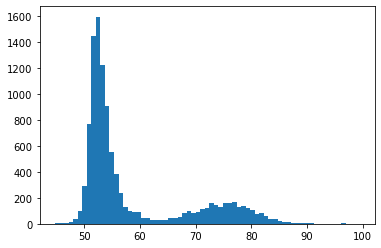

In [34]:
fig, ax = plt.subplots()

n, bins, _ = ax.hist(dt, bins='auto')

n.size, bins.size

We have to compute the bin centres to put them in the right place on the _x_ axis.

In [35]:
bins = (bins[1:] + bins[:-1]) / 2

<BarContainer object of 67 artists>

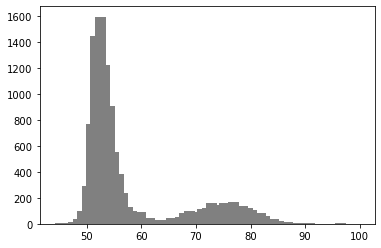

In [36]:
fig, ax = plt.subplots()

ax.bar(bins, n, width=2, color='gray')

We'd often like to get statistics from our data:

In [37]:
p50 = np.percentile(dt, 50)
p50

nan

In [38]:
dtn = dt[~np.isnan(dt)]

Now we can compute some stats and use them in the bar plot:

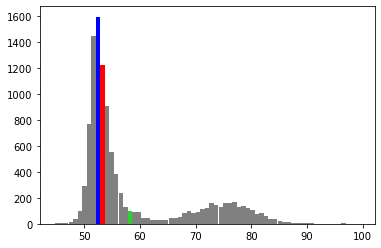

In [39]:
# For example, we could compute the bin containing the median value:
p50 = np.percentile(dtn, 50)
med_bin = np.argmin(np.abs(bins - p50))

# And the bin containing the mode:
mode_bin = np.argmax(n)

# And the bin containing the mean:
mean_bin = np.argmin(np.abs(bins - dtn.mean()))

colours = ['gray' for b in bins]
colours[med_bin] = 'r'
colours[mode_bin] = 'b'
colours[mean_bin] = 'limegreen'

fig, ax = plt.subplots()
ax.bar(bins, n, width=0.8, color=colours)
plt.show()

The fact that out `mean` is very different from our `mode` and `median` is one clue that we are not dealing with a normal distribution.

# `plt.imshow()` for raster data

For image-like data, such as FMI logs or slices of seismic, we need a different kind of visualization. 

NB There's also `plt.pcolor` but it's very slow. Use `plt.pcolormesh` instead.

## FMI visualization and analysis
The DLIS file we are going to use in this next section is 73 MB.

A physical DLIS file, i.e. a regular file on disk, is segmented into multiple Logical Files. Think of a DLIS file as folder-structure. The DLIS file itself is the folder, and the Logical Files are the actual files.

A `PhysicalFile` object is essentially a tuple of all the Logical Files in a regular file, and that is what is being returned when we use `load`. 


In [40]:
%load_ext autoreload
%autoreload 2

#### The data is here https://geocomp.s3.amazonaws.com/data/FMI_Run3_processed.dlis

In [41]:
fmi_name = '../data/FMI_Run3_processed.dlis'

The following cell uses a helper function to return a small 6 foot section – from 7520 to 7526 ft – of the FMI log from within the file given by `fname`. For details on how this is implemented, see `get_fmi_segment()` in `dlis_utils.py`. 

In [42]:
depth_sm, fmi_sm = dlis_utils.get_fmi_segment(fmi_name, top=7520, base=7526)

In [43]:
fmi_sm.shape

(720, 360)

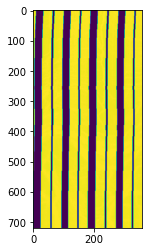

In [44]:
fig, ax = plt.subplots()
ax.imshow(fmi_sm)

### extent ###

One of the first things we'll want to do is give our plot some physical dimensions.
We can do that using the `extent` keyword which takes a sequence of four values in the order of: `left`, `right`, `bottom`, `top`.

In [45]:
xmin, xmax, bot, top = 0, 359, depth_sm[-1], depth_sm[0]

In [46]:
extent = xmin, xmax, bot, top

We're going to use this tuple so often, let's just give it the same name as the keyword argument used in `imshow()`

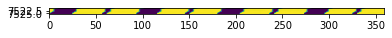

In [47]:
fig, ax = plt.subplots()
ax.imshow(fmi_sm, extent=extent)

### aspect ###

Why does this look so flat? Even though we have 720 samples along the vertical dimension and 360 samples along the horizontal dimension, we are telling Matplotlib that the extent spans a 6 units vertically, and 360 units horizontal. Matplotlib doesn't know what `aspect` ratio to use, so it uses a one-to-one aspect ratio unless you tell it otherwise.

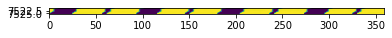

In [48]:
fig, ax = plt.subplots()
ax.imshow(fmi_sm, extent=extent, aspect='equal')

To make square pixels – such as with an actual photograph – we could set `aspect = 60` (360 sample wide / 6 feet high). But we aren't dealing with a square image necessarily. This will usually be the case everytime you have axes with different units.

Change the aspect ratio to `auto` and it will come up with something more reasonable. We'll want to adjust this later to represent "true" aspect ratio (and that will require us to convert angles to the perimeter distance along the borehole)

Also, let's label the axes to remind us what we're working with.

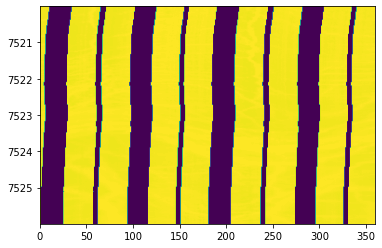

In [49]:
fig, ax = plt.subplots()
ax.imshow(fmi_sm, extent=extent, aspect='auto')

Ok, so now the tick labels on the axes seem to make sense (we will assign labels on them soon), but there is still something very wrong with the colours.

What is the problem with this image? What do the colours represent?

## Adding a colorbar
Using the pyplot interface, adding a colorbar is straightforward:

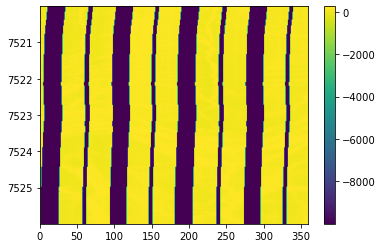

In [50]:
plt.imshow(fmi_sm, extent=extent, aspect='auto')
plt.colorbar()

Using the object-oriented interface, if you want to add a colorbar you have two options. The first, is that you either can add to the figure which does essentially the same thing as above. The second is to create a separate axis for it. Either way you need to store the `ScalarMappable` return from `ax.imshow` and then pass that into the `colorbar()` function. 

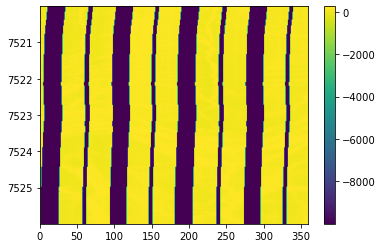

In [51]:
fig, ax = plt.subplots()
im = ax.imshow(fmi_sm, extent=extent, aspect='auto')
fig.colorbar(im)

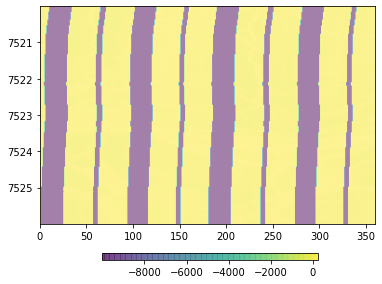

In [52]:
fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.0, 0.5, 0.025])
im = ax.imshow(fmi_sm, extent=extent, aspect='auto', alpha=0.5)
fig.colorbar(im, cax=cax, orientation='horizontal')

### Exercise

- For the colours: Hint add `plt.colorbar()` beneath the last line in the cell above.
– If you are stuck, try adding `clim=[0,255]` in the `plt.imshow()` function call. What it happening? Why is this not an _actual_ fix to the problem?
- Overwrite `fmi_sm with a new array where the problem is fixed.

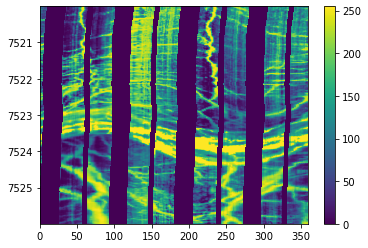

In [53]:
# this is not an elegant way to fix the missing data samples
fig, ax = plt.subplots()
im = ax.imshow(fmi_sm, extent=extent, aspect='auto', clim=[0,255])
fig.colorbar(im)

In [54]:
# Let's look at the min and max value in this array
print(np.amax(fmi_sm), np.amin(fmi_sm))

255.00002 -9999.0


In [55]:
# change all the -9999.0 to NaNs.
fmi_sm[fmi_sm == -9999.0] = np.nan

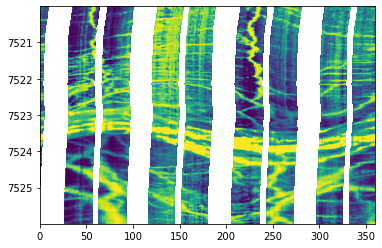

In [56]:
plt.imshow(fmi_sm, extent=extent, aspect='auto')

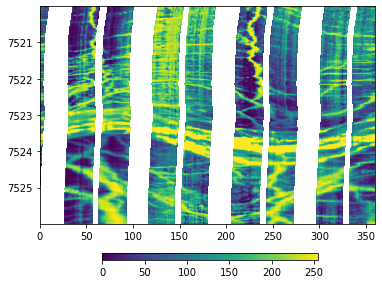

In [57]:
fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.0, 0.5, 0.025])
im = ax.imshow(fmi_sm, extent=extent, aspect='auto')
fig.colorbar(im, cax=cax, orientation='horizontal')

## Choosing colormaps. 
You seldom need to create your own colormaps in Matplotlib, because you've got so many great options to [choose from](https://matplotlib.org/stable/tutorials/colors/colormaps.html). But if you need to reproduce an industry standard such as the FMI disaplay, there are ways to do tha as well.
https://matplotlib.org/3.1.0/tutorials/colors/colormap-manipulation.html

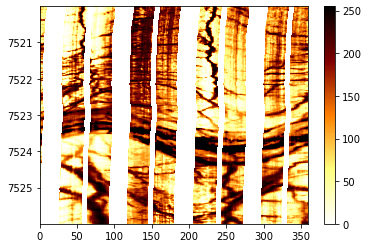

In [58]:
plt.imshow(fmi_sm, extent=extent, aspect='auto', cmap='afmhot_r')
plt.colorbar()

`afm_hot` is not particularly ideal as one of the Perceptually Uniform choices (e.g. `viridis`, `plasma`, `inferno`, `magma` and `cividis`) but it _is_ quite similar to the industry standard plots of which people may be familiar. 

In a recent release of Matplotlib, a colormap object's `__repr__()` returns a view of the colormap like so:

In [59]:
cmap = plt.get_cmap('afmhot_r')
cmap

It also suffers in the sense that "bad" or "missing" data gets mapped to the same colour as values "under" the color limit range. This could be misleading, and `viridis` avoids this. White is reserved for missing values.

In [60]:
cmap = plt.get_cmap('viridis')
cmap

There are ways to create your own colormaps, but you'll probably be able to get most of your work done without having to create your own. 

For [manipulating colormaps](https://matplotlib.org/stable/tutorials/colors/colormap-manipulation.html) you'll need to get familiar with `ListedColormaps` and `LinearSegmentedColormaps`.

Once you've created an instance of a colormap, as you'd expect, you pass in a value between zero and 1 and get the corresponding color for that value. `imshow()` uses this internally to paint the pixels according to their numerical values, and does the normalization based on the ranges in the data.

In [61]:
from matplotlib import cm
afmhot_r = cm.get_cmap('afmhot_r', 8)
print(afmhot_r(-0.2)) # out of range
print(afmhot_r(0.7)) # within range
print(afmhot_r(1.2)) # within range

(1.0, 1.0, 1.0, 1.0)
(0.5714285714285716, 0.07142857142857162, 0.0, 1.0)
(0.0, 0.0, 0.0, 1.0)


In [62]:
import matplotlib
from IPython.display import Markdown

def hex_color(rgba):
    return matplotlib.colors.to_hex(rgba)

color = hex_color(afmhot_r(0.5))
display (Markdown(f'<h2><span style="color: {color}">Selected color</span></h2>'))

<h2><span style="color: #db5b00">Selected color</span></h2>

In [63]:
from ipywidgets import interact

cmap_selector = ['afmhot_r', 'Greys', 'seismic', 'magma', 'inferno']
ncolours = 24
@interact(v=(0,1,0.01), cmaps=cmap_selector)
def color_words(v=0.8, cmaps='afmhot_r'):
    cmap = cm.get_cmap(cmaps, 24)
    rounded_vals = tuple([float("{0:.2f}".format(n)) for n in cmap(v)])
    color = hex_color(cmap(v))
    display (Markdown(f'<h3><span style="color: {color}">SELECTED COLOR: {rounded_vals}</span></h3>'))
    fig, ax = plt.subplots()
    ax.imshow(np.expand_dims(np.linspace(0,1,ncolours), axis=-1).T, cmap=cmap, aspect=4)
    ax.axvline(v * ncolours, color='r')

interactive(children=(FloatSlider(value=0.8, description='v', max=1.0, step=0.01), Dropdown(description='cmaps…

## Modifying the aspect ratio

For `imshow()` within an axes, you'll need to learn how to set the aspect ratio for you image, especially when your image is not truly a photograph-type image (like our FMI example), and the dimensions of your array have different units.

When you create an axes object for your plot, it occupies a certain part of the figure (or canvas if you like). Depending on the size of the figure and the size of the axes, this may or may not be what you want.



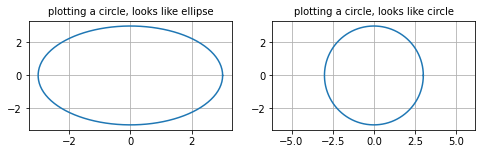

In [64]:
# Setting aspect on regular (non-imshow) axes
# Plot circle of radius 3.
an = np.linspace(0, 2 * np.pi, 100)
fig, axs = plt.subplots(1, 2, figsize=(8,2))

axs[0].plot(3 * np.cos(an), 3 * np.sin(an))
axs[0].set_title('plotting a circle, looks like ellipse', fontsize=10)
axs[0].grid()

axs[1].plot(3 * np.cos(an), 3 * np.sin(an))
axs[1].axis('equal')
axs[1].set_title('plotting a circle, looks like circle', fontsize=10)
axs[1].grid()

In [65]:
diam = 8 / 12  # diameter of hole is 8" or 8/12 feet
perim = np.pi * diam 
aspect = 360 / perim  # ratio of width to feet along the horizontal

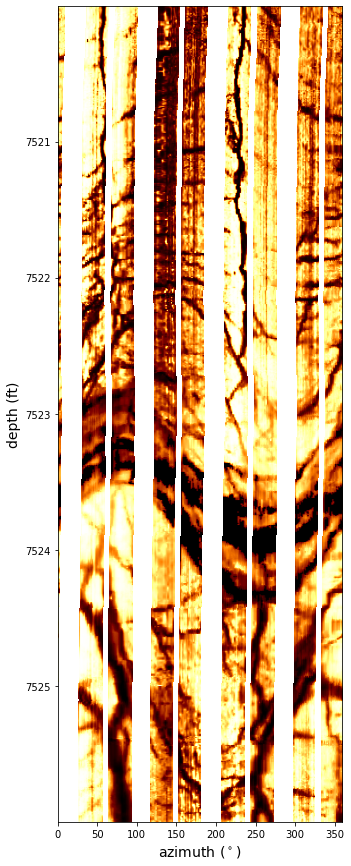

In [66]:
plt.figure(figsize=(10,15))
plt.imshow(fmi_sm,  aspect=aspect, extent=extent, cmap='afmhot_r')
plt.ylabel('depth (ft)', fontsize= 14)
_ = plt.xlabel(r'azimuth ($^\circ$)', fontsize=14)

### Exercise
- Take the code above and put it into function that takes the numpy arr `arr` and the `extent` and returns the `fig` and `ax` show above.
- Stretch goal, change the x-axis labels and x-axis tick locations that read angles every 45 degrees along the perimeter (Hint: you'll likely wand to use abd `ax` axes object for this)

In [67]:
def imshow_fmi(arr, extent):
    """Docstring goes here"""
    # your code goes here
    return

In [68]:
def imshow_fmi(ax, arr, extent, **kwargs):
    ax.imshow(arr,  aspect=aspect, extent=extent, cmap='afmhot_r', **kwargs)
    ax.set_xticks(np.linspace(0, extent[1], 9))  # ticks every 45 degrees
    ax.set_xticklabels(np.arange(0, 361, 45))  # labels every 45 degrees
    ax.set_ylabel('Measured depth (ft)', size=14)
    ax.set_xlabel(r'Azimuth ($^o$)', size=14)
    ax.grid(alpha=0.5)
    return ax

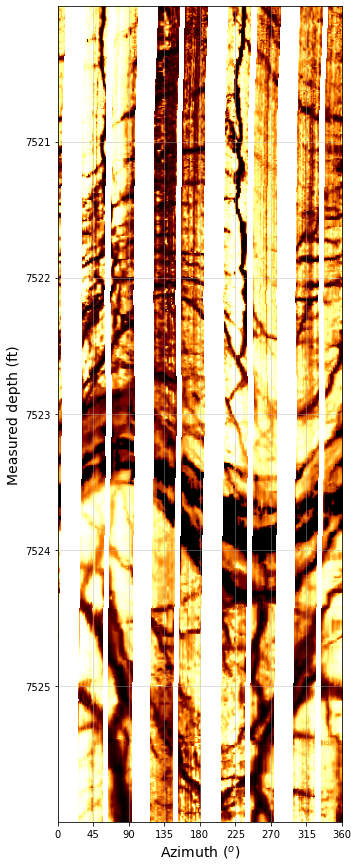

In [69]:
# Running this cell should produce the same output as the previous cell.
fig, ax = plt.subplots(figsize=(10,15))
_ = imshow_fmi(ax, fmi_sm, extent)

### Exercise

$y = A*sin(x - \phi) + y_{0}$ 

- Write a function that generates a sine wave given a y-value, an amplitude, and a phase. The sine-wave should go from zero to 360 degrees.
- Plot a single sine wave on a graph.
- Create a small set of sine waves and plot them on the same axis.

In [70]:
def sine_wave(amp=1, phase=0, z0=0, diam=8/12, return_x=True):
    """
    Return the A * six(x - phi) + 
    x is 0-360 in degrees
    A is amplitude
    phi is phase in degrees
    return_x = True return x-basis in degrees
    """
    #circum = np.pi*diam
    x = np.arange(0, 2 * np.pi, 0.05)
    phase =  phase * (np.pi / 180)
    y = amp * np.sin(x - phase) + z0
    x_theta = np.linspace(0, 361, len(x))
    if return_x:
        return x_theta, y
    else:
        return y
    

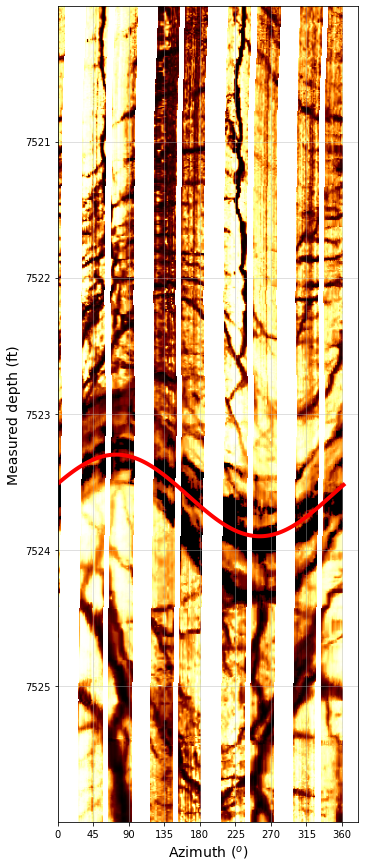

In [71]:
# plot the fmi image
fig, ax = plt.subplots(figsize=(10,15))
imshow_fmi(ax, fmi_sm, extent)# plot the sine wave
ax.plot(*sine_wave(amp=0.3, phase=253.2 - 90, z0=7523.6), c='r', lw=4)

In [72]:
# plot the fmi image
from ipywidgets import interact

@interact(z=(top, bot, 0.1), alpha=(0,1,0.1))
def adjust_feature(z=7523.6, alpha=1.0):
    fig, ax = plt.subplots(figsize=(10,15))
    imshow_fmi(ax, fmi_sm, extent, alpha=alpha)
    ax.plot(*sine_wave(amp=0.3, phase=253.2 - 90, z0=z), c='r', lw=4)

interactive(children=(FloatSlider(value=7523.6, description='z', max=7525.998203217983, min=7520.0065365513165…

### Exercise
Calculate the dip implied by this sine wave. Assume the hole is 8 inches wide.

Then you can calculate the dip $theta$ using the relation,

$A = r\tan\theta$

where $r$ is the radius of the borehole (in feet), $A$ is the amplitude of the sine wave (in feet) and $theta$ is the dip of the feature.

In [73]:
def amp_from_dip(theta, r=4/12):
    """Returns the amplitude height (in feet) sine wave representing a dipping
    plane at angle theta through a cylindrical 
    borehole of radius r"""
    return r * np.tan(np.pi * theta / 180)


def dip_from_amplitude(a, r=4/12):
    """Returns the dip angle in degrees of a sine wave (plane) amplitude a
    along a borehole of radius r. We aren't using this function in this 
    notebook, but we would need it if we want to convert sine waves to
    strikes and dips"""
    return 180 * np.arctan(a / r) / np.pi

In [74]:
dip, azi, z0 =  42.31818, -16.06800, 23

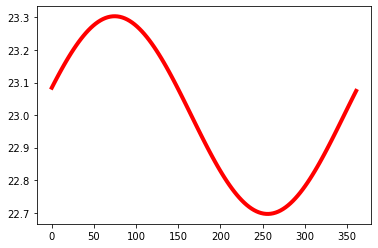

In [75]:
plt.plot(*sine_wave(amp=amp_from_dip(dip), phase=azi, z0=z0), c='r', lw=4)

Notice in mind that depth increases upwards in this plot, so it will look flipped compared to below

Let's grab some features that have already been picked. They are in an `xlsx` file. We can use pandas to read this file and explore it's contents. There are 125 features in this file...let's focus on the ones that are in our 5 ft area of interest.

In [76]:
# Just some operations to get us a DataFrame of the data in the interval of interest

feats = pd.read_excel('https://geocomp.s3.amazonaws.com/data/FMI_run2_feature_picks.xlsx', engine='openpyxl')
feat_zone = feats[(feats.TDEP > top) & (feats.TDEP < bot)]
feats = feat_zone[['TDEP','Azimuth', 'Dip_TRU', 'Type']]  # we only need these columns
feats['Azimuth'] = feats['Azimuth'] - 90  # azimuth is relative to North.
feats

<ipython-input-76-bebef24723a1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats['Azimuth'] = feats['Azimuth'] - 90  # azimuth is relative to North.


TDEP    Azimuth   Dip_TRU                                Type
84  7521.061523  139.99510  86.26883            Tensile_Induced_Fracture
85  7521.871419  226.53360  20.17180  Conductive_Part_Resistive_Fracture
86  7522.177303  202.95180  60.52354  Conductive_Part_Resistive_Fracture
87  7522.336224  175.79410  32.57280  Conductive_Part_Resistive_Fracture
88  7522.858121  182.17000  24.63936  Conductive_Part_Resistive_Fracture
89  7522.883493  147.65860  42.55340  Conductive_Part_Resistive_Fracture
90  7523.238325  163.93200  42.31818      Conductive_Continuous_Fracture
91  7523.513050  162.61390  51.94371  Conductive_Part_Resistive_Fracture
92  7523.514721  163.18420  47.95513      Conductive_Continuous_Fracture
93  7524.104117  -54.99737  19.89306  Conductive_Part_Resistive_Fracture
94  7524.165342   59.11400  56.73015  Conductive_Part_Resistive_Fracture
95  7524.628636   89.98460  66.71805  Conductive_Part_Resistive_Fracture
96  7524.808623   72.02320  51.41504  Conductive_Part_Resistive_Fracture
97  7524.864901   92.07660  52.96983  Conductive_Part_Resistive_Fracture
98  7525.117128   97.90630  64.71487  Conductive_Part_Resistive_Fracture
99  7525.975687   91.95940  72.58805  Conductive_Part_Resistive_Fracture

One issue, that isn't easily apparent from the data is that the FMI has 0 azimuth directed towards _east_ whereas the features data set has azimuth measurements relative to _north_. Therefor to display the features on the FMI we need to subtract 90 degrees from each of them.


In [77]:
def plot_features(ax, df, color_dict):
    for i, row in df.iterrows():
        ax.plot(*sine_wave(amp=amp_from_dip(row.Dip_TRU), 
                           phase=row.Azimuth,
                           z0=row.TDEP),
                color=color_dict[row.Type], 
                lw=3)
    return ax

In [78]:
colors = {'Tensile_Induced_Fracture': 'darkgreen',
          'Conductive_Part_Resistive_Fracture': 'blue',
          'Conductive_Continuous_Fracture': 'red'}

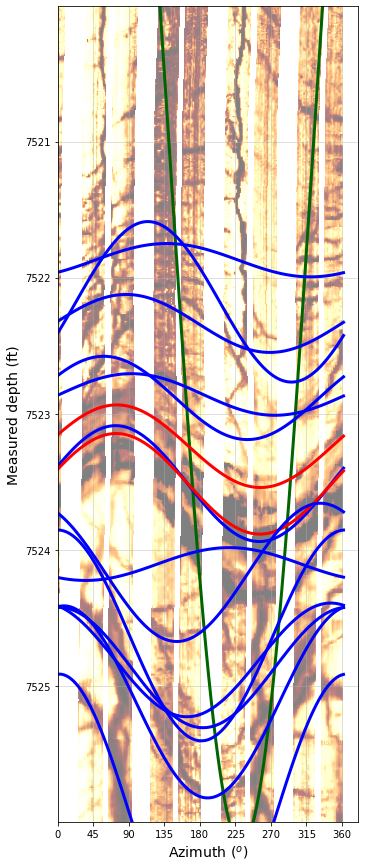

In [79]:
fig, ax = plt.subplots(figsize=(10,15))
imshow_fmi(ax, fmi_sm, extent, alpha=0.5)
plot_features(ax, feats, colors)
_ = ax.set_ylim(bot, top)

We are going to draw tadpole-like arrows for the azimuth of these fractures. To do so we need to know the x-component, "u" and the y-component "v" of the azimuth vector. So we can create two new `Series` in our dataFrame.
We could also just store these as numpy arrays.

In [80]:
# arrow directions for tadpole plot
feats['v'] = np.cos(np.pi * feats.Azimuth / 180)
feats['u'] = np.sin(np.pi * feats.Azimuth / 180)

<ipython-input-80-1128a2744025>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats['v'] = np.cos(np.pi * feats.Azimuth / 180)
<ipython-input-80-1128a2744025>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats['u'] = np.sin(np.pi * feats.Azimuth / 180)


In [81]:
feats['color'] = feats.Type.map(colors)
feats

<ipython-input-81-b4631f84d5a4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feats['color'] = feats.Type.map(colors)


TDEP    Azimuth   Dip_TRU                                Type  \
84  7521.061523  139.99510  86.26883            Tensile_Induced_Fracture   
85  7521.871419  226.53360  20.17180  Conductive_Part_Resistive_Fracture   
86  7522.177303  202.95180  60.52354  Conductive_Part_Resistive_Fracture   
87  7522.336224  175.79410  32.57280  Conductive_Part_Resistive_Fracture   
88  7522.858121  182.17000  24.63936  Conductive_Part_Resistive_Fracture   
89  7522.883493  147.65860  42.55340  Conductive_Part_Resistive_Fracture   
90  7523.238325  163.93200  42.31818      Conductive_Continuous_Fracture   
91  7523.513050  162.61390  51.94371  Conductive_Part_Resistive_Fracture   
92  7523.514721  163.18420  47.95513      Conductive_Continuous_Fracture   
93  7524.104117  -54.99737  19.89306  Conductive_Part_Resistive_Fracture   
94  7524.165342   59.11400  56.73015  Conductive_Part_Resistive_Fracture   
95  7524.628636   89.98460  66.71805  Conductive_Part_Resistive_Fracture   
96  7524.808623   72.02320  51.41504  Conductive_Part_Resistive_Fracture   
97  7524.864901   92.07660  52.96983  Conductive_Part_Resistive_Fracture   
98  7525.117128   97.90630  64.71487  Conductive_Part_Resistive_Fracture   
99  7525.975687   91.95940  72.58805  Conductive_Part_Resistive_Fracture   

           v         u      color  
84 -0.765989  0.642853  darkgreen  
85 -0.687929 -0.725778       blue  
86 -0.920833 -0.389957       blue  
87 -0.997307  0.073341       blue  
88 -0.999283 -0.037865       blue  
89 -0.844876  0.534963       blue  
90 -0.960934  0.276778        red  
91 -0.954313  0.298809       blue  
92 -0.957240  0.289296        red  
93  0.573614 -0.819126       blue  
94  0.513332  0.858190       blue  
95  0.000269  1.000000       blue  
96  0.308632  0.951182       blue  
97 -0.036236  0.999343       blue  
98 -0.137553  0.990494       blue  
99 -0.034191  0.999415       blue

## Tadpole plot
We can achieve a tadplot plot, but using a combination of `quiver` and `scatter` functions.
`quiver` takes four inputs to draw each line segment: The `origin` of the point, and the horizontal `u` and vertical `v` components of the line segment. The dictionary `quiveropts` helps style the line segment. The default looks more like an arrow as this function is regularly used in plotting vector fields.

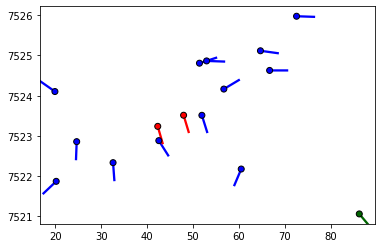

In [82]:
fig, ax = plt.subplots()
r = 4 # quiver len
quiveropts = dict(pivot='tail', headlength=0, headaxislength=0, units='x', width=.5, headwidth=1)
origin = np.array([feats.Dip_TRU, feats.TDEP]) # head of tadpoles
ax.quiver(*origin, r*feats['u'], r*feats['v'], color=feats['color'], **quiveropts) 
ax.scatter(*origin, edgecolor='k', facecolor=feats['color'])

Combining the various components we've created so far:

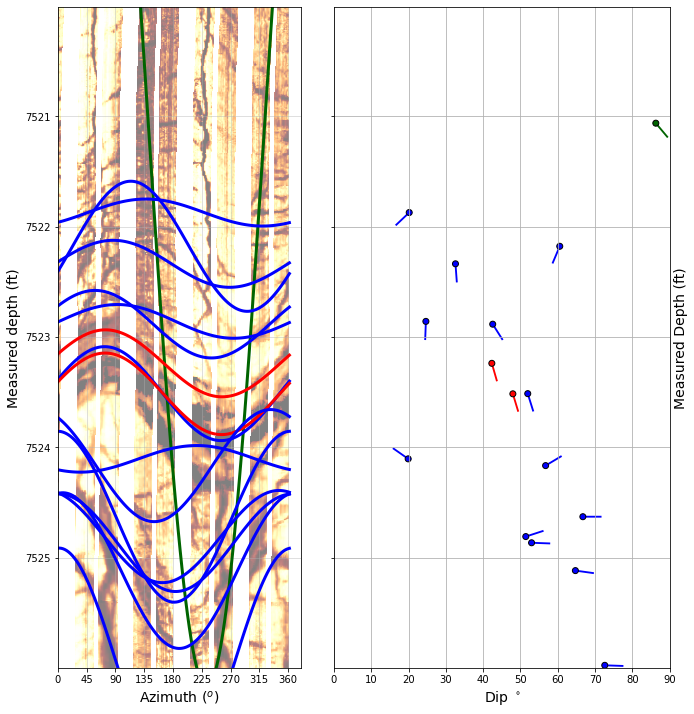

In [83]:
fig, axs = plt.subplots(ncols=2, figsize=(10,10), gridspec_kw={'width_ratios': [1, 1]})
ax = axs[0]
imshow_fmi(ax, fmi_sm, extent, alpha=0.5)
plot_features(ax, feats, colors)
ax.tick_params(labelright=False)    
ax.set_ylim(bot, top)

ax = axs[1]
r = 4 # quiver len
quiveropts = dict(pivot='tail', headlength=0, headaxislength=0, units='x', width=.5, headwidth=1)
origin = np.array([feats.Dip_TRU, feats.TDEP]) # head of tadpoles
ax.quiver(*origin, r*feats['u'], r*feats['v'], color=feats['color'], **quiveropts) 
ax.scatter(*origin, edgecolor='k', facecolor=feats['color'])
ax.set_ylim(bot, top)
ax.set_xlim(0, 90)
ax.set_xlabel(r'Dip $^\circ$', size=14)
ax.yaxis.set_label_position('right')
ax.grid()
ax.tick_params(labelleft=False)    
ax.set_ylabel('Measured Depth (ft)', size=14)

fig.tight_layout(pad=1.0)

# Sonic Scanner example

#### Download the data from here > https://geocomp.s3.amazonaws.com/data/UniversityOfUtah_MU-ESW1_DSI_PnS-Aniso_SecondPass.dlis

In [84]:
fname = '../data/UniversityOfUtah_MU-ESW1_DSI_PnS-Aniso_SecondPass.dlis'

f, *f_tail = dlisio.dlis.load(fname)   

In [85]:
dlis_utils.print_frame_summary(f)

frame  0
name                  : PLOT_BOTTOM_DM
description           : 
index_type            : BOREHOLE-DEPTH
index_min/max         : 7270.0, 7500.0, ft
index_channel.units   : ft
direction             : INCREASING
spacing               : 0.5 ft
index_channel         : Channel(MD)
No. of channels       : 38



In [86]:
channel_table = dlis_utils.summarize(f.channels, name='Name', long_name='Long name', units='Units',
                                      dimension='Dimension', frame='Frame')
channel_table.sort_values('Name')

Frame                           Name  \
1   Frame(PLOT_BOTTOM_DM)                             BS   
2   Frame(PLOT_BOTTOM_DM)                           DPHZ   
3   Frame(PLOT_BOTTOM_DM)                           DTCO   
4   Frame(PLOT_BOTTOM_DM)                      DTSM_FAST   
5   Frame(PLOT_BOTTOM_DM)                      DTSM_SLOW   
6   Frame(PLOT_BOTTOM_DM)                   FSA_ERRMINUS   
7   Frame(PLOT_BOTTOM_DM)                    FSA_ERRPLUS   
8   Frame(PLOT_BOTTOM_DM)                       FSA_P1AZ   
9   Frame(PLOT_BOTTOM_DM)                        GR_EDTC   
10  Frame(PLOT_BOTTOM_DM)                          HAZIM   
11  Frame(PLOT_BOTTOM_DM)                           HDAR   
12  Frame(PLOT_BOTTOM_DM)          MAXXENE_OVERALL_BCR_5   
0   Frame(PLOT_BOTTOM_DM)                             MD   
13  Frame(PLOT_BOTTOM_DM)          MINXENE_OVERALL_BCR_5   
14  Frame(PLOT_BOTTOM_DM)                           P1AZ   
15  Frame(PLOT_BOTTOM_DM)                           PEFZ   
16  Frame(PLOT_BOTTOM_DM)                        PR_FAST   
17  Frame(PLOT_BOTTOM_DM)                           RHOZ   
18  Frame(PLOT_BOTTOM_DM)                          SDEVM   
19  Frame(PLOT_BOTTOM_DM)                       SFA_FAST   
20  Frame(PLOT_BOTTOM_DM)                       SFA_SLOW   
21  Frame(PLOT_BOTTOM_DM)                         SLOANI   
22  Frame(PLOT_BOTTOM_DM)                           SPHI   
23  Frame(PLOT_BOTTOM_DM)                       SPR_FAST   
24  Frame(PLOT_BOTTOM_DM)                        SPR_MPS   
25  Frame(PLOT_BOTTOM_DM)                       SPR_SLOW   
26  Frame(PLOT_BOTTOM_DM)                      SWF7_FAST   
27  Frame(PLOT_BOTTOM_DM)                      SWF7_SLOW   
28  Frame(PLOT_BOTTOM_DM)  TDIF_ALT_OVERALL_BCR_5_SWAP_6   
29  Frame(PLOT_BOTTOM_DM)  TDIF_ORG_OVERALL_BCR_5_SWAP_6   
30  Frame(PLOT_BOTTOM_DM)                           TENS   
31  Frame(PLOT_BOTTOM_DM)                         TIMANI   
32  Frame(PLOT_BOTTOM_DM)                           TNPH   
33  Frame(PLOT_BOTTOM_DM)                           TW_B   
34  Frame(PLOT_BOTTOM_DM)                           TW_E   
35  Frame(PLOT_BOTTOM_DM)                      VPVS_FAST   
36  Frame(PLOT_BOTTOM_DM)                       WF_MPS_R   
37  Frame(PLOT_BOTTOM_DM)                        XENEDIF   

                                            Long name     Units Dimension  
1                                            Bit Size        in       [1]  
2           Standard Resolution Density Porosity {F11   ft3/ft3       [1]  
3                              Compressional slowness     us/ft       [1]  
4                                      Shear slowness     us/ft       [1]  
5                                      Shear slowness     us/ft       [1]  
6   Fast shear azimuth error minus(NAZ REF90) - sw...       deg       [1]  
7   Fast shear azimuth error plus(NAZ REF90) - swa...       deg       [1]  
8   Fast shear azimuth(NAZ REF90) - overall - swapped       deg       [1]  
9                                           Gamma Ray      gAPI       [1]  
10                                                          deg       [1]  
11                            Hole Diameter from Area        in       [1]  
12                     Maximum cross energy - overall  unitless       [1]  
0                                                            ft       [1]  
13                     Minimum cross energy - overall  unitless       [1]  
14  Pad 1 Azimuth in Horizontal Plane (0 = True No...       deg       [1]  
15  Standard Resolution Formation Photoelectric Fa...                 [1]  
16                               Fast Poisson's Ratio  unitless       [1]  
17         Standard Resolution Formation Density {F11     g/cm3       [1]  
18                                                          deg       [1]  
19                        Slowness frequency analysis  unitless      [76]  
20                        Slowness frequency analysis  unitless      [76]  
21     

In [87]:
# Get the depth array
depth = f.channels[0].curves()

# Get the DTSM_Fast curve and set -999.25 to nan
dtsm_fast = f.channels[4].curves()  
dtsm_fast[dtsm_fast == -999.25] = np.nan

# Get the SPR_FAST scan and corresponding depth
scan = f.channels[23].curves()
scan[scan == -999.25] = np.nan

# Create a travel-time axis for the waveform scans
tt_basis = np.linspace(60,360,76)  # I can't find this in the file, but gleaned this from the plots

# xarray – N-D dimensional labeled datasets

In [88]:
import xarray as xr

In [89]:
scan_xr = xr.DataArray(scan, 
                       name=f.channels[19].name,
                       coords=[depth, tt_basis],
                       dims=['depth','slowness'],
                       )

In [90]:
scan_xr

<xarray.DataArray 'SFA_FAST' (depth: 461, slowness: 76)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.69845223, 0.75789183, 0.8136724 , ..., 0.02625466, 0.02695428,
        0.02807207],
       [0.69802815, 0.75741726, 0.81314814, ..., 0.02595455, 0.02675526,
        0.02799838],
       ...,
       [0.50089604, 0.56501454, 0.62822384, ..., 0.06001933, 0.06188017,
        0.06389788],
       [0.43159223, 0.49149302, 0.5541829 , ..., 0.0763804 , 0.0760865 ,
        0.0753977 ],
       [0.53399986, 0.5983105 , 0.6608712 , ..., 0.03743592, 0.03754136,
        0.03791206]], dtype=float32)
Coordinates:
  * depth     (depth) float64 7.27e+03 7.27e+03 7.271e+03 ... 7.5e+03 7.5e+03
  * slowness  (slowness) float64 60.0 64.0 68.0 72.0 ... 348.0 352.0 356.0 360.0

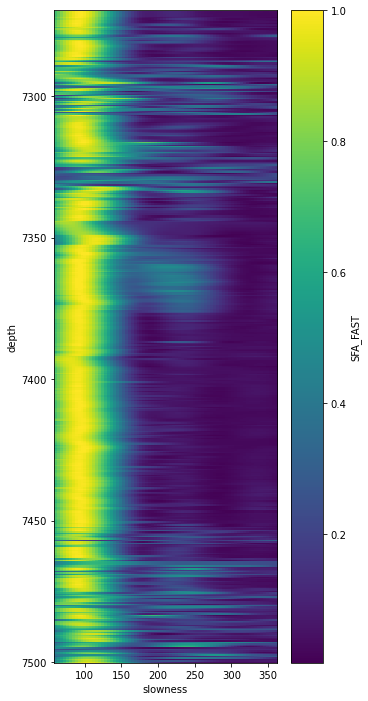

In [91]:
scan_xr.plot.imshow(figsize=(5,12), aspect=30, origin='upper') 

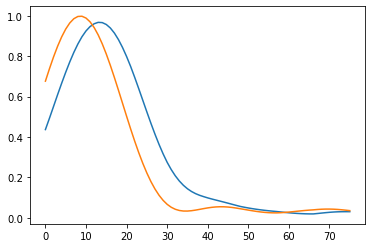

In [92]:
for k in [7350, 7450]:
    plt.plot(scan_xr.loc[k])  # this is the actual depth value.

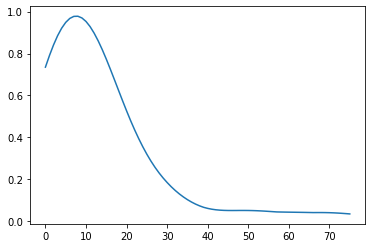

In [93]:
# Look up waveform value by selecting a value along the depth dimension
# Use the `sel` method to use the labels, use `isel` instead for integer indexing.
# For inexact matches we need to set the "method", and tolerance. Tolerance should be the sample interval
plt.plot(scan_xr.sel(depth=7400.999, method='nearest', tolerance=0.5))  

# How about some peak finding?

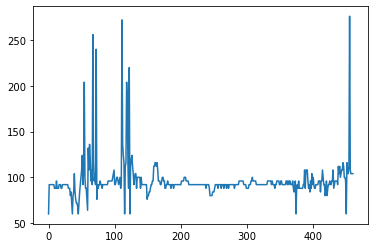

In [94]:
peaks = np.apply_along_axis(np.argmax, axis=1, arr=scan)
computed_slowness = tt_basis[peaks]
plt.plot(computed_slowness)

# Plotting it all up

In [95]:
from ipywidgets import interact
curve_shift_x = 0
depth_loc= 7400.999
gain = -5
ymin, ymax = 7290, 7305

@interact(wave_depth=(ymin, ymax, 0.1), gain=(0.1,10,0.1))
def scanner_plot(wave_depth, gain=1):
    fig, ax = plt.subplots(figsize=(4,15))
    ma = np.percentile(scan, 99)
    im = ax.imshow(scan, clim=(0.0,1.0), 
              extent=[tt_basis[0], tt_basis[-1], depth.max(), depth.min()], 
              aspect='auto', cmap='viridis',
              alpha=0.75)
    ax.plot(dtsm_fast + curve_shift_x, depth, color='w', lw=4)  # highlighting the line underneath
    ax.plot(dtsm_fast + curve_shift_x, depth, color='k')
    
    ax.plot(computed_slowness, depth, color='r')
    depth_id = 7310
    if True:
        wave = scan_xr.sel(depth=wave_depth, method='nearest', tolerance=0.5)
        ax.axhline(wave_depth, color='w', lw=4)
        ax.axhline(wave_depth, color='k', lw=1) 
        ax.plot(tt_basis, wave_depth - gain * wave, 'w', lw=4)  
        ax.plot(tt_basis, wave_depth - gain * wave, 'k')  

    _ = ax.set_yticks(np.arange(depth.min(), depth.max(), 5))
    ax.set_xlabel('slowness µs/ft')
    ax.set_ylabel('measured depth ft')
    ax.set_ylim(ymax, ymin)
    plt.colorbar(im)

interactive(children=(FloatSlider(value=7297.0, description='wave_depth', max=7305.0, min=7290.0), FloatSlider…

Can you improve the peak finding in the troublesome areas? What techniques could you employ?

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2021</p>
</div>